In [1]:
import nutpie
import pathlib
import arviz
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import posteriordb
import json
import cmdstanpy
import time
import fastprogress
import pandas as pd
import xarray as xr

In [2]:
import logging
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

In [3]:
# Install cmdstan if necessary...
#cmdstanpy.install_cmdstan()

In [4]:
db = posteriordb.PosteriorDatabase("../../posteriordb/posterior_database/")

In [5]:
def store_trace(storage, name, kind, tr):
    tr.to_netcdf(f"{storage}/{name}_{kind}.nc")
    ess = arviz.ess(tr)
    ess.to_netcdf(f"{storage}/{name}_{kind}_ess.nc")

In [13]:
n_tune = 300

In [14]:
def sample_nutpie(posterior, *, storage, n_chains=12, overwrite=True):
    if os.path.exists(f"{storage}/{name}_nutpie.nc") and not overwrite:
        return
    with open(posterior.data.file_path()) as file:
        data = json.load(file)
    code = posterior.model.code("stan")
    compiled = nutpie.compile_stan_model(data, code=code)
    start = time.time()
    tr = nutpie.sample(compiled, chains=n_chains, seed=1, progress_bar=False, draws=1000, tune=n_tune,
                       store_gradient=True, store_mass_matrix=True, store_unconstrained=True)
    end = time.time()
    tr.posterior.attrs["sampling_time"] = end - start
    store_trace(storage, posterior.name, "nutpie", tr)

def sample_stan(posterior, *, n_chains=12, storage, overwrite=False):
    if os.path.exists(f"{storage}/{name}_stan.nc") and not overwrite:
        return
    cmd_model = cmdstanpy.CmdStanModel(posterior.model.name, posterior.model.code_file_path("stan"))
    with open(posterior.data.file_path()) as file:
        data = json.load(file)
    start = time.time()
    trace = cmd_model.sample(data, chains=n_chains, save_warmup=True,
                             show_progress=False, seed=1, iter_warmup=n_tune, iter_sampling=1000)
    end = time.time()
    tr = arviz.from_cmdstanpy(trace, save_warmup=True)
    tr.posterior.attrs["sampling_time"] = end - start
    store_trace(storage, posterior.name, "stan", tr)

In [15]:
storage = f"/mnt/harddrives/data_labs/covadapt-paper/2022-11-07-model-zoo_{n_tune}_grad_init"

In [16]:
!mkdir -p {storage}

In [17]:
names = db.posterior_names()

traces_nutpie = []
traces_stan = []

ess_nutpie = []
ess_stan = []

times_nutpie = []
times_stan = []

model_names = []
failed_models = []
errors = []

for name in fastprogress.progress_bar(names):
    # Those models don't really converge, and they take *a long time*
    if "covid" in name:
        continue
    # Another slow one...
    if "hmm" in name:
        continue
    if "election88_full" in name:
        continue
    if "nn_rbm" in name:
        continue
    if "ldaK5" in name:
        continue
    if "prostate-logistic_regression_rhs" in name:
        continue
        
    # Strange error during compilation
    if "sir-sir" in name:
        continue

    try:
        sample_nutpie(db.posterior(name), storage=storage, overwrite=True)
        sample_stan(db.posterior(name), storage=storage, overwrite=False)
    except (ValueError, RuntimeError, IndexError) as error:
        #print(f"failure for model {name}: {error}")
        errors.append(error)
        failed_models.append(name)
    else:
        model_names.append(name)    

Worker thread failed: Could not send sample to controller thread


In [12]:
len(errors)

4

In [11]:
print(errors)

[RuntimeError("Error during sampling:\nException: integrate_ode_rk45: initial state[1] is inf, but must be finite! (in '/home/adr/git/posteriordb/posterior_database/models/stan/lotka_volterra.stan', line 32, column 2 to line 35, column 42)\n\tException: integrate_ode_rk45: initial state[1] is inf, but must be finite! (in '/home/adr/git/posteriordb/posterior_database/models/stan/lotka_volterra.stan', line 32, column 2 to line 35, column 42)\n\tException: lognormal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/home/adr/git/posteriordb/posterior_database/models/stan/lotka_volterra.stan', line 44, column 4 to column 47)\n\tException: lognormal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/home/adr/git/posteriordb/posterior_database/models/stan/lotka_volterra.stan', line 44, column 4 to column 47)\n\tException: lognormal_lpdf: Location parameter[1] is -nan, but must be finite! (in '/home/adr/git/posteriordb/posterior_database/models/stan/lotka_volterra.stan

In [11]:
failed_models

['hudson_lynx_hare-lotka_volterra',
 'mcycle_gp-accel_gp',
 'science_irt-grsm_latent_reg_irt',
 'dogs-dogs_log']

In [ ]:
plt.plot(times_nutpie)
plt.plot(times_stan)

In [12]:
model_names[30]

IndexError: list index out of range

In [13]:
# at 67

In [14]:
#model 17 is interesting

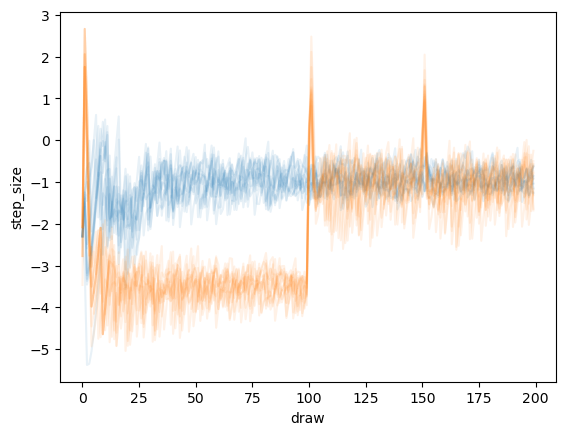

In [58]:
idx = 2
tr_nutpie = arviz.from_netcdf(f"{storage}/{model_names[idx]}_nutpie.nc")
tr_stan = arviz.from_netcdf(f"{storage}/{model_names[idx]}_stan.nc")

np.log(tr_nutpie.warmup_sample_stats.step_size).plot.line(x="draw", color="C0", alpha=0.1, add_legend=False)
np.log(tr_stan.warmup_sample_stats.step_size).plot.line(x="draw", color="C1", alpha=0.1, add_legend=False)


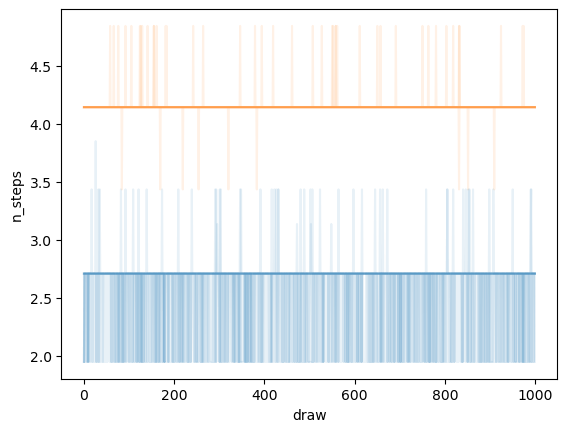

In [13]:
np.log(tr_nutpie.sample_stats.n_steps).plot.line(x="draw", add_legend=False, color="C0", alpha=0.1)
np.log(tr_stan.sample_stats.n_steps).plot.line(x="draw", add_legend=False, color="C1", alpha=0.1)

In [14]:
failed_models

['dogs-dogs_log',
 'hudson_lynx_hare-lotka_volterra',
 'mcycle_gp-accel_gp',
 'science_irt-grsm_latent_reg_irt']

In [15]:
errors[2]

ValueError('Logp function returned error Initialization of first point failed')

In [29]:
model_names[idx]

'Rate_4_data-Rate_4_model'

In [47]:
good[0] = False

NameError: name 'good' is not defined

In [19]:
print(db.posterior(name).model.code("stan"))

data {
  int<lower=0> J;
  int<lower=0> N;
  int<lower=1,upper=J> county_idx[N];
  vector[N] log_uppm;
  vector[N] floor_measure;
  vector[N] log_radon;
}
parameters {
  vector[J] alpha;
  vector[2] beta;
  real mu_alpha;
  real<lower=0> sigma_alpha;
  real<lower=0> sigma_y;
}
model {
  vector[N] mu;
  vector[N] muj;

  sigma_alpha ~ normal(0, 1);
  sigma_y ~ normal(0, 1);
  mu_alpha ~ normal(0, 10);
  beta ~ normal(0, 10);

  alpha ~ normal(mu_alpha, sigma_alpha);
  for(n in 1:N){
    muj[n] = alpha[county_idx[n]] + log_uppm[n] * beta[1];
    mu[n] = muj[n] + floor_measure[n] * beta[2];
    target += normal_lpdf(log_radon[n] | mu[n], sigma_y);
  }
}



In [174]:
name

'wells_data-wells_dist'

In [175]:
np.log(times_nutpie) - np.log(times_stan)

array([], dtype=float64)

<AxesSubplot: >

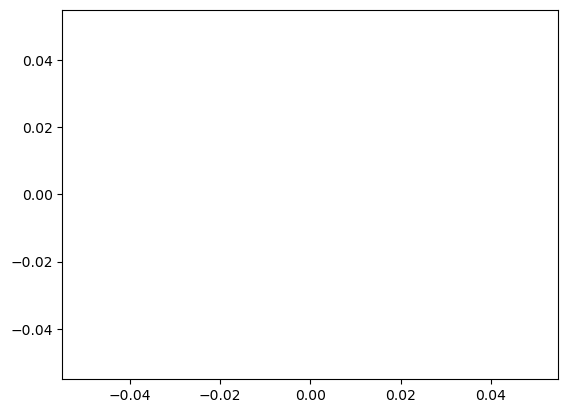

In [176]:
sns.histplot(np.log(times_nutpie) - np.log(times_stan))

In [12]:
def find_discrete(tr):
    is_discrete = ((tr.posterior == tr.posterior.round()).sum() > 100).to_array()
    if all(is_discrete):
        return []
    return list(is_discrete.where(is_discrete, np.nan).dropna("variable")["variable"].values)

In [13]:
posterior_grad_evals_nutpie = []
posterior_grad_evals_stan = []

grad_evals_nutpie = []
grad_evals_stan = []

divs_stan = []
divs_nutpie = []

ess_mins_nutpie = []
ess_mins_stan = []

times_nutpie = []
times_stan = []

for i, name in enumerate(model_names):
    try:
        tr_nutpie = arviz.from_netcdf(f"{storage}/{name}_nutpie.nc")
        tr_stan = arviz.from_netcdf(f"{storage}/{name}_stan.nc")
    except FileNotFoundError:
        continue
    divs_stan.append(tr_stan.sample_stats.diverging.sum())
    divs_nutpie.append(tr_nutpie.sample_stats.diverging.sum())
    posterior_grad_evals_nutpie.append(tr_nutpie.sample_stats.n_steps.sum())
    posterior_grad_evals_stan.append(tr_stan.sample_stats.n_steps.sum())
    grad_evals_nutpie.append(posterior_grad_evals_nutpie[-1] + tr_nutpie.warmup_sample_stats.n_steps.sum())
    grad_evals_stan.append(posterior_grad_evals_stan[-1] + tr_stan.warmup_sample_stats.n_steps.sum())

    times_nutpie.append(tr_nutpie.posterior.attrs["sampling_time"])
    times_stan.append(tr_stan.posterior.attrs["sampling_time"])

    discrete = find_discrete(tr_nutpie)

    ess_nutpie = xr.open_dataset(f"{storage}/{name}_nutpie_ess.nc")
    ess_stan = xr.open_dataset(f"{storage}/{name}_stan_ess.nc")
    ess_mins_nutpie.append(ess_nutpie.drop_vars(discrete).min().to_array().min().values)
    ess_mins_stan.append(ess_stan.drop_vars(discrete).min().to_array().min().values)

In [14]:
divs_stan = np.array(divs_stan)
divs_nutpie = np.array(divs_nutpie)
grad_evals_nutpie = np.array(grad_evals_nutpie)
grad_evals_stan = np.array(grad_evals_stan)
posterior_grad_evals_nutpie = np.array(posterior_grad_evals_nutpie)
posterior_grad_evals_stan = np.array(posterior_grad_evals_stan)
ess_mins_nutpie = np.array(ess_mins_nutpie)
ess_mins_stan = np.array(ess_mins_stan)
times_nutpie = np.array(times_nutpie)
times_stan = np.array(times_stan)

In [33]:
#good = ((divs_stan < 10) | (divs_nutpie < 10)) & ((ess_mins_nutpie > 200) | (ess_mins_stan > 200))
good_stan = (divs_stan < 5) & (ess_mins_stan > 500)
good_nutpie = (divs_nutpie < 5) & (ess_mins_nutpie > 500)
good = good_stan | good_nutpie

In [34]:
(divs_stan < 5).sum()

97

In [35]:
(divs_nutpie < 5).sum()

98

In [36]:
good_stan.sum()

84

In [37]:
good_nutpie.sum()

89

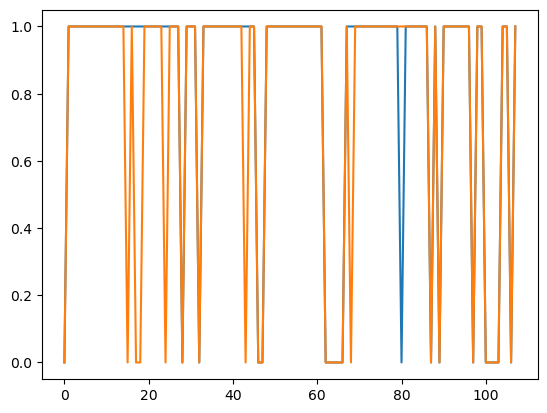

In [38]:
plt.plot(good_nutpie)
plt.plot(good_stan)

In [19]:
model_names[67]

'radon_all-radon_county_intercept'

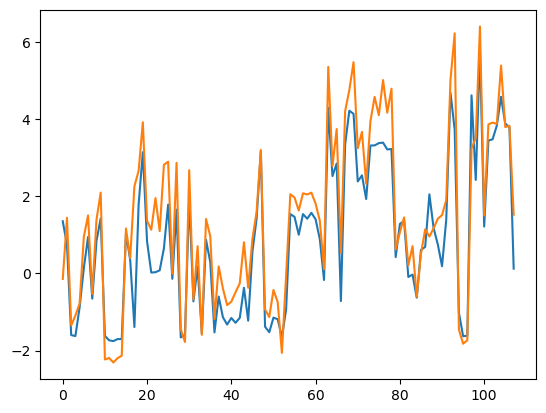

In [20]:
plt.plot(np.log(times_nutpie))
plt.plot(np.log(times_stan))

<AxesSubplot: ylabel='Count'>

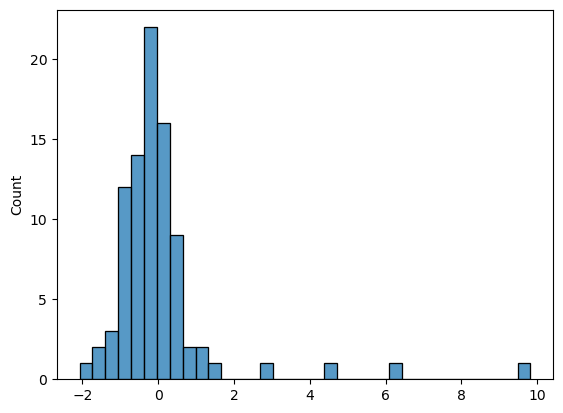

In [21]:
sns.histplot(np.log2(ess_mins_nutpie / ess_mins_stan)[good])

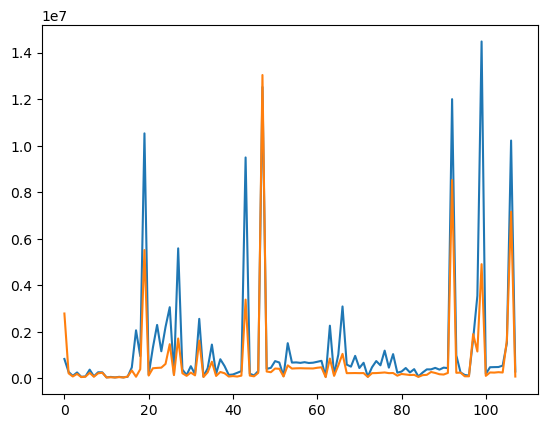

In [22]:
plt.plot(grad_evals_stan)
plt.plot(grad_evals_nutpie)

In [23]:
import pandas as pd

In [24]:
df = pd.DataFrame({"stan": divs_stan, "nutpie": divs_nutpie}).unstack().rename("divergences")
df.index.names = ["sampler", "model"]

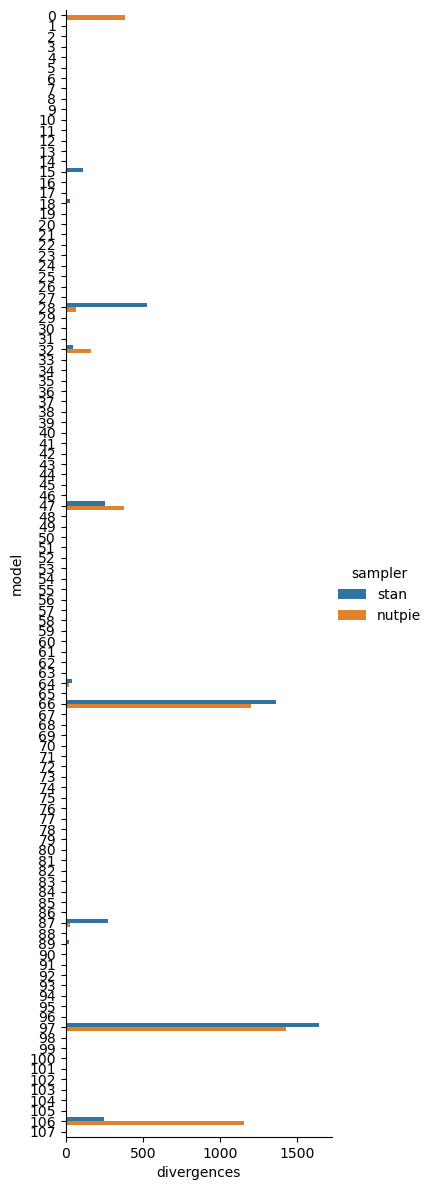

In [25]:
sns.catplot(df.reset_index(), hue="sampler", x="divergences", y="model", orient="h", kind="bar", aspect=0.3, height=12)

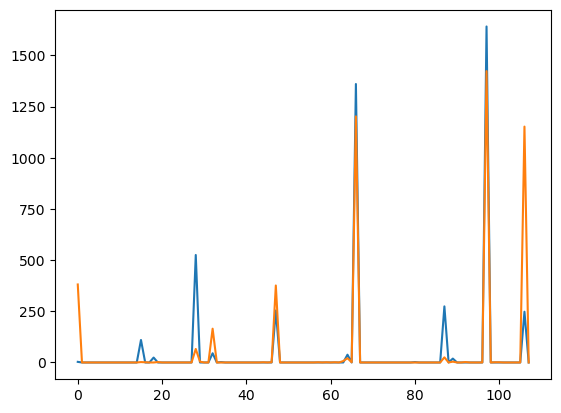

In [26]:
plt.plot(divs_stan)
plt.plot(divs_nutpie)

<AxesSubplot: ylabel='Count'>

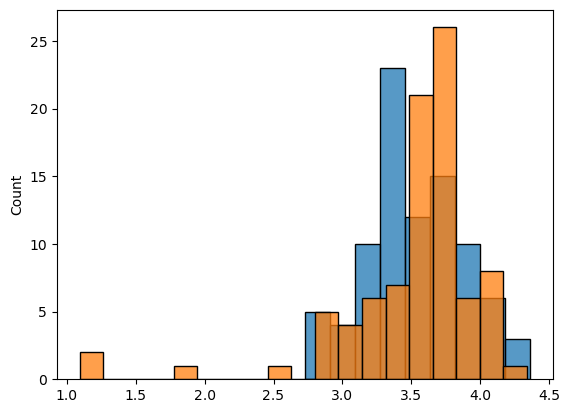

In [27]:
sns.histplot(np.log10(ess_mins_nutpie)[good])
sns.histplot(np.log10(ess_mins_stan)[good])

<AxesSubplot: ylabel='Count'>

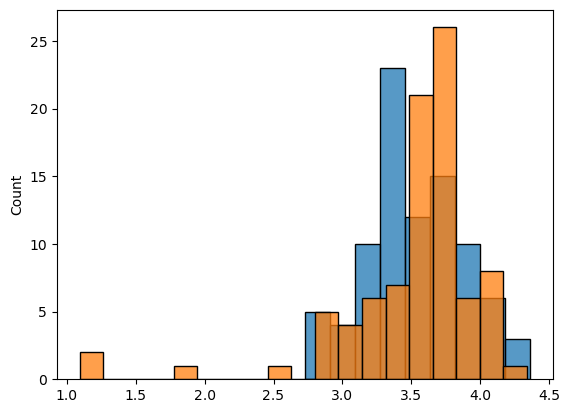

In [28]:
sns.histplot(np.log10(ess_mins_nutpie)[good])
sns.histplot(np.log10(ess_mins_stan)[good])

<AxesSubplot: ylabel='Count'>

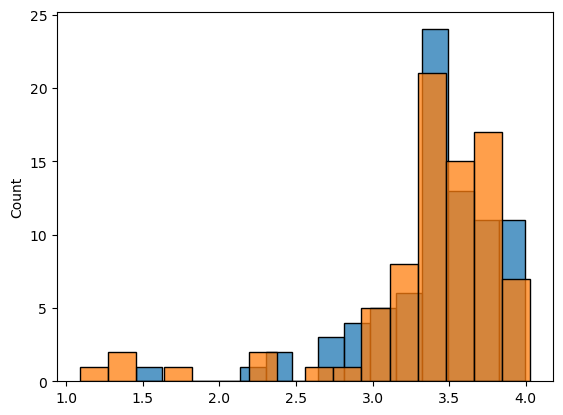

In [31]:
sns.histplot(np.log10(ess_mins_nutpie)[good])
sns.histplot(np.log10(ess_mins_stan)[good])

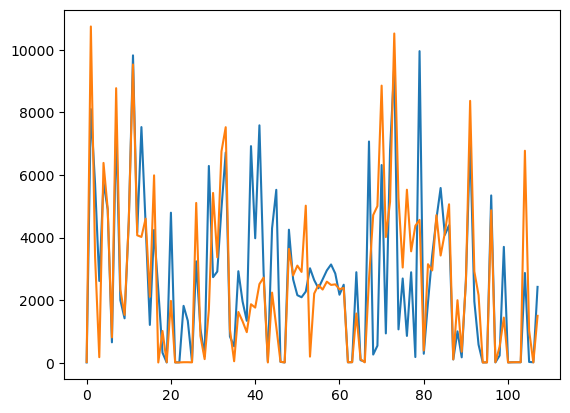

In [32]:
plt.plot(ess_mins_nutpie)
plt.plot(ess_mins_stan)

Text(0.5, 1.0, 'Effective sample size per (warmup + sampling) grad evals')

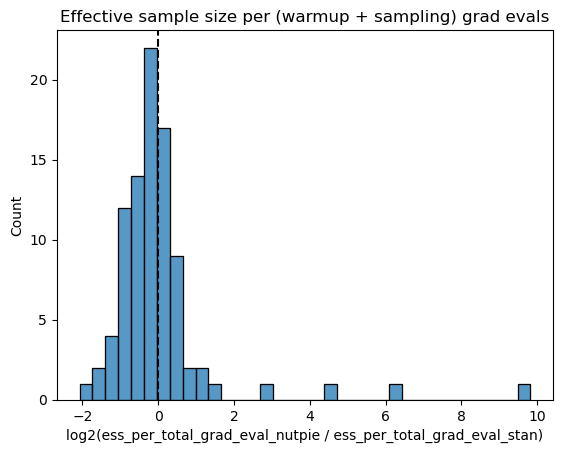

In [39]:
sns.histplot(np.log2(((np.array(ess_mins_nutpie)) / (np.array(ess_mins_stan))))[good])
plt.axvline(0, color="black", linestyle="--")
plt.xlabel("log2(ess_per_total_grad_eval_nutpie / ess_per_total_grad_eval_stan)")
plt.title("Effective sample size per (warmup + sampling) grad evals")

In [40]:
2 ** np.log2((np.array(ess_mins_nutpie) / grad_evals_nutpie) / (np.array(ess_mins_stan) / grad_evals_stan))[good].mean()

2.008640143130617

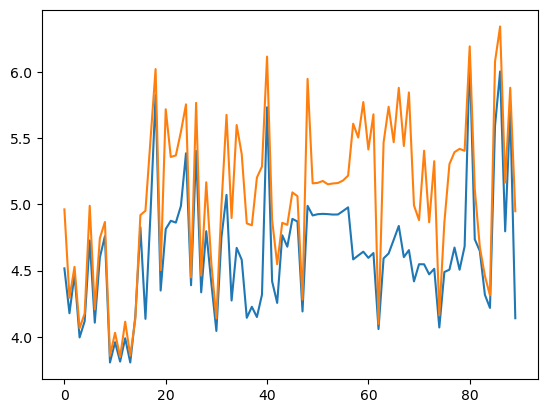

In [41]:
plt.plot(np.log10(grad_evals_nutpie - posterior_grad_evals_nutpie)[good])
plt.plot(np.log10(grad_evals_stan - posterior_grad_evals_stan)[good])

Text(0.5, 1.0, 'Warmup gradient evaluations for different models')

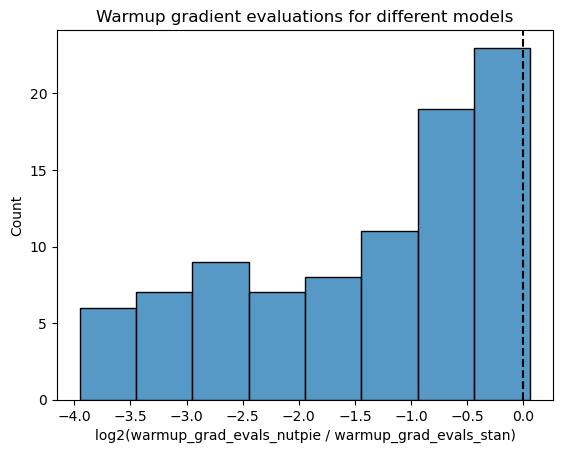

In [42]:
sns.histplot(np.log2(grad_evals_nutpie - posterior_grad_evals_nutpie)[good] - np.log2(grad_evals_stan - posterior_grad_evals_stan)[good])
plt.axvline(0, color="black", linestyle="--")
plt.xlabel("log2(warmup_grad_evals_nutpie / warmup_grad_evals_stan)")
plt.title("Warmup gradient evaluations for different models")

In [73]:
np.log2((np.array(ess_mins_nutpie) / grad_evals_nutpie) / (np.array(ess_mins_stan) / grad_evals_stan))[good]

array([ 6.12009413e-02,  1.96770387e-01,  4.76552260e-01,  1.12571388e+00,
       -1.18448440e-01,  2.34464898e-02,  4.12523952e-01,  1.15045054e-01,
        2.05491651e-01,  5.12390941e-01,  4.99446356e-01,  3.25050356e-01,
        7.92581450e-01,  2.58233782e-01,  9.89185825e-02,  1.48266612e+01,
       -2.76075458e-01,  4.56541559e-01,  7.28446181e-01,  5.93556143e-01,
        3.73875125e-01,  4.57157432e-01,  4.30902827e-01,  8.91449970e-02,
        4.54960940e-01, -5.00640480e-03,  1.80958234e-01,  1.06198236e+00,
        4.18853605e-01,  2.54671248e-01,  5.30332925e-01,  4.81918777e-01,
        3.32194372e-01,  4.68860220e-01,  6.74127761e-01,  1.13370313e+00,
        1.22033979e+00,  3.44989712e-01,  8.91474938e-01, -7.09543332e-02,
       -1.48099592e-01, -1.29282027e-01, -1.82258963e-01, -1.29509892e-01,
       -4.66182722e-03,  7.62298675e-01,  2.75647103e-01,  2.76071449e-01,
        2.73275839e-01,  2.71507544e-01,  2.34118341e-01,  3.11445754e-01,
        2.03810409e-01,  

Text(0.5, 1.0, 'Effective sample size per (warmup + sampling) grad evals')

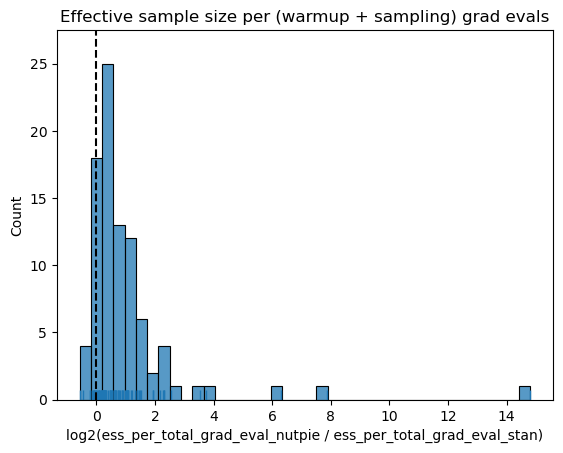

In [43]:
sns.histplot(np.log2((np.array(ess_mins_nutpie) / grad_evals_nutpie) / (np.array(ess_mins_stan) / grad_evals_stan))[good])
sns.rugplot(np.log2((np.array(ess_mins_nutpie) / grad_evals_nutpie) / (np.array(ess_mins_stan) / grad_evals_stan))[good])
plt.axvline(0, color="black", linestyle="--")
#plt.xlim(-1, 3)
plt.xlabel("log2(ess_per_total_grad_eval_nutpie / ess_per_total_grad_eval_stan)")
plt.title("Effective sample size per (warmup + sampling) grad evals")

In [44]:
2 ** np.log2((np.array(ess_mins_nutpie) / posterior_grad_evals_nutpie) / (np.array(ess_mins_stan) / posterior_grad_evals_stan))[good].mean()

1.6297722255088978

Text(0.5, 1.0, 'Effective sample size per sampling grad evals (excluding warmup)')

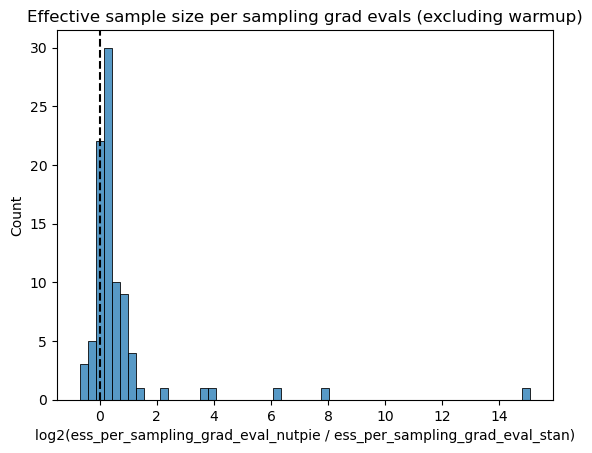

In [45]:
sns.histplot(np.log2((np.array(ess_mins_nutpie) / posterior_grad_evals_nutpie) / (np.array(ess_mins_stan) / posterior_grad_evals_stan))[good])
plt.axvline(0, color="black", linestyle="--")
#plt.xlim(-1, 3)
plt.xlabel("log2(ess_per_sampling_grad_eval_nutpie / ess_per_sampling_grad_eval_stan)")
plt.title("Effective sample size per sampling grad evals (excluding warmup)")

<AxesSubplot: ylabel='Count'>

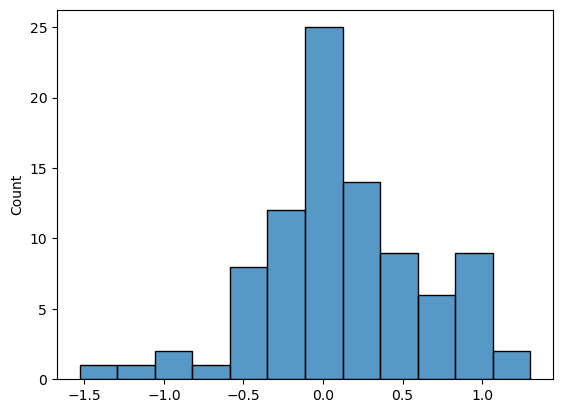

In [46]:
sns.histplot((np.log2((times_nutpie / grad_evals_nutpie)) - (np.log2(times_stan / grad_evals_stan)))[good])
#plt.plot(np.log((times_stan / grad_evals_stan))[good])

In [47]:
2 ** np.log2((np.array(ess_mins_nutpie) / np.array(times_nutpie)) / (np.array(ess_mins_stan) / np.array(times_stan)))[good].mean()

1.8521679335501404

Text(0.5, 1.0, 'Effective sample size per total time (warmup and tuning)')

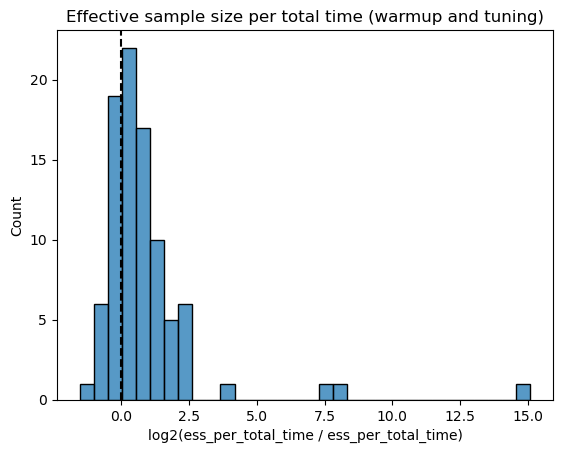

In [48]:
sns.histplot(np.log2((np.array(ess_mins_nutpie) / np.array(times_nutpie)) / (np.array(ess_mins_stan) / np.array(times_stan)))[good])
plt.axvline(0, color="black", linestyle="--")
#plt.xlim(-2, 3)
plt.xlabel("log2(ess_per_total_time / ess_per_total_time)")
plt.title("Effective sample size per total time (warmup and tuning)")

In [50]:
times_stan.sum()

3428.105152130127

In [51]:
times_nutpie.sum()

1534.0842726230621

Text(0.5, 1.0, 'Effective sample size per total time (warmup and tuning)')

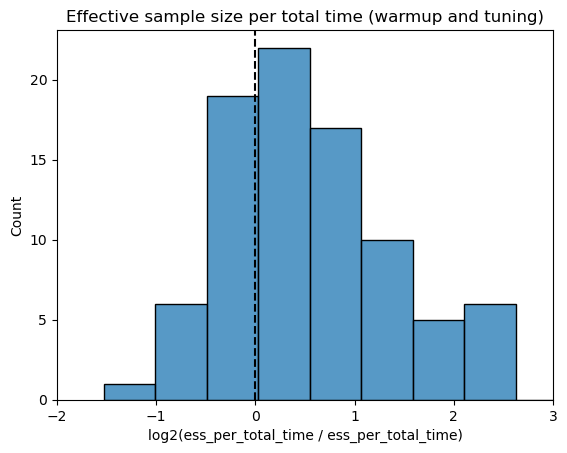

In [54]:
sns.histplot(np.log2((np.array(ess_mins_nutpie) / np.array(times_nutpie)) / (np.array(ess_mins_stan) / np.array(times_stan)))[good])
plt.axvline(0, color="black", linestyle="--")
plt.xlim(-2, 3)
plt.xlabel("log2(ess_per_total_time / ess_per_total_time)")
plt.title("Effective sample size per total time (warmup and tuning)")

In [55]:
2 ** (np.log2((np.array(ess_mins_nutpie) / np.array(times_nutpie)) / (np.array(ess_mins_stan) / np.array(times_stan)))[good]).mean()

1.8521679335501404

<AxesSubplot: ylabel='Count'>

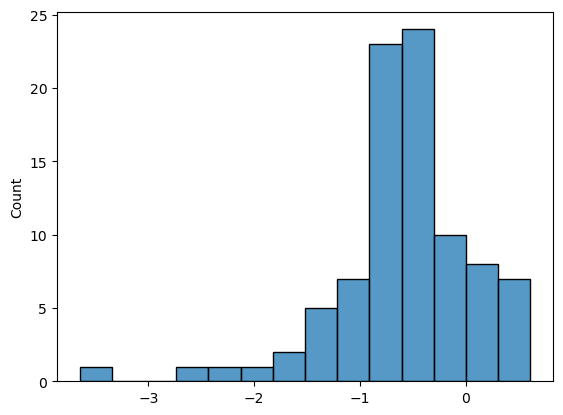

In [56]:
sns.histplot((np.log(times_nutpie) - np.log(times_stan))[good])

<AxesSubplot: ylabel='Count'>

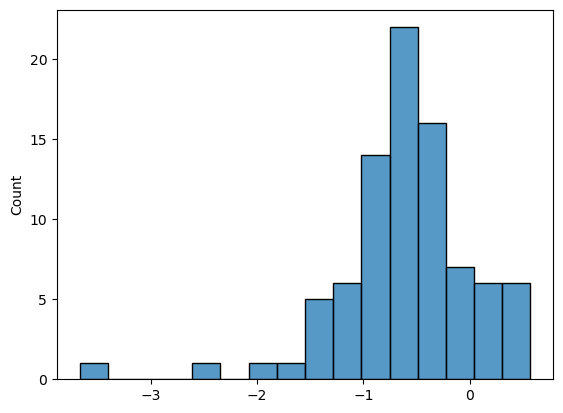

In [76]:
sns.histplot((np.log(times_nutpie) - np.log(times_stan))[good])

In [111]:
discrete_names = find_discrete(tr)

NameError: name 'tr' is not defined

In [112]:
tr_stan = arviz.from_cmdstanpy(trace, save_warmup=True)

NameError: name 'trace' is not defined

In [113]:
arviz.ess(tr_stan).drop_vars(discrete_names).min()

NameError: name 'discrete_names' is not defined

In [19]:
arviz.ess(tr).min()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    omega    float64 1.29e+04
    mean_p   float64 1.214e+04
    sigma    float64 6.326e+03
    eps_raw  float64 5.976e+04
    eps      float64 1.448e+04
    mean_lp  float64 1.214e+04
    logit_p  float64 2.662e+04
    p        float64 2.662e+04
    z        float64 4.389e+03
    N        float64 8.032e+03

In [20]:
(arviz.ess(tr).min() / tr.sample_stats.n_steps.sum()) / (arviz.ess(tr_stan).min() / tr_stan.sample_stats.n_steps.sum())

<xarray.Dataset>
Dimensions:  ()
Data variables:
    omega    float64 1.143
    mean_p   float64 1.172
    sigma    float64 1.113
    eps_raw  float64 1.257
    eps      float64 1.116
    mean_lp  float64 1.172
    logit_p  float64 1.06
    p        float64 1.06
    z        float64 0.1046
    N        float64 1.157

In [44]:
ess_stan = arviz.ess(tr_stan)

In [45]:
ess = arviz.ess(tr)

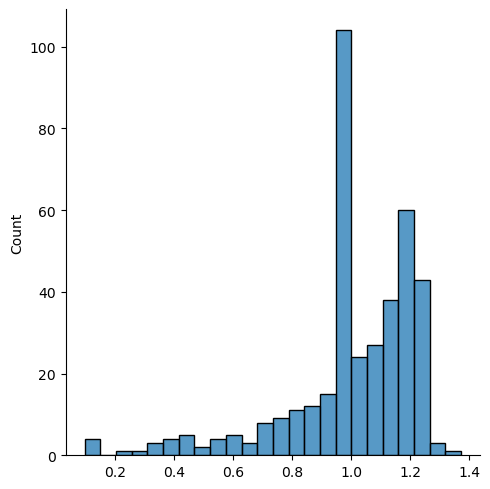

In [49]:
sns.displot(ess.z / ess_stan.z)

In [46]:
ess_stan.z

<xarray.DataArray 'z' (z_dim_0: 387)>
array([50000.        , 50000.        , 50000.        , 50000.        ,
       50000.        , 50000.        , 50000.        , 50000.        ,
       50000.        , 50000.        , 50000.        , 50000.        ,
       50000.        , 50000.        , 50000.        , 50000.        ,
       50000.        , 50000.        , 50000.        , 50000.        ,
       50000.        , 50000.        , 50000.        , 50000.        ,
       50000.        , 50000.        , 50000.        , 50000.        ,
       50000.        , 50000.        , 50000.        , 50000.        ,
       50000.        , 50000.        , 50000.        , 50000.        ,
       50000.        , 50000.        , 50000.        , 50000.        ,
       50000.        , 50000.        , 50000.        , 50000.        ,
       50000.        , 50000.        , 50000.        , 50000.        ,
       50000.        , 50000.        , 50000.        , 50000.        ,
       50000.        , 50000.        , 50000.        , 50000.        ,
       50000.        , 50000.        , 50000.        , 50000.        ,
       50000.        , 50000.        , 50000.        , 50000.        ,
       50000.        , 50000.        , 50000.        , 50000.        ,
       50000.        , 50000.        , 50000.        , 50000.        ,
       50000.        , 50000.        , 50000.        , 50000.        ,
       50000.        , 50000.        , 50000.        , 50000.        ,
...
       47366.04524409, 45996.67196537, 47150.7357433 , 48582.88177563,
       47023.12140844, 47752.35546126, 46937.16892729, 45977.39004065,
       47566.94475686, 47675.97990414, 46624.08428832, 46796.95156784,
       47811.90609327, 43358.67820733, 49407.55154878, 46420.97621224,
       48024.36778647, 44946.03002207, 44397.01180805, 48372.12549983,
       47542.27528269, 49659.87369864, 46706.58518238, 46780.24338363,
       46042.86292657, 48143.40950089, 46084.55951584, 48102.74844672,
       46716.66320221, 46690.67705146, 48073.36558166, 46248.12339042,
       46226.90696475, 47372.52130102, 47974.2650476 , 47683.9103486 ,
       47852.5271493 , 45012.11884122, 46124.74763741, 46016.83191003,
       45903.23578749, 46653.65358274, 45860.94985376, 46989.50249006,
       45933.49636111, 47347.19393684, 44378.4220743 , 46467.77205491,
       49260.31268044, 46394.39786232, 46203.5404086 , 46617.41973305,
       46015.49208284, 47072.41717526, 46460.17399361, 48440.88788114,
       45543.31743728, 47146.89143003, 47085.91034418, 45777.43395546,
       46654.08566417, 46809.45345267, 44317.00624417, 41974.59623447,
       46174.49575987, 45898.62427785, 48558.62295077, 46147.79858515,
       47003.26509884, 47952.09583233, 46683.15475178, 46882.58618381,
       44182.33761973, 46192.36293386, 47311.5735737 , 48509.29573507,
       47428.61533887, 47128.11544218, 45852.62275596])
Coordinates:
  * z_dim_0  (z_dim_0) int64 0 1 2 3 4 5 6 7 ... 379 380 381 382 383 384 385 386

<AxesSubplot: ylabel='Count'>

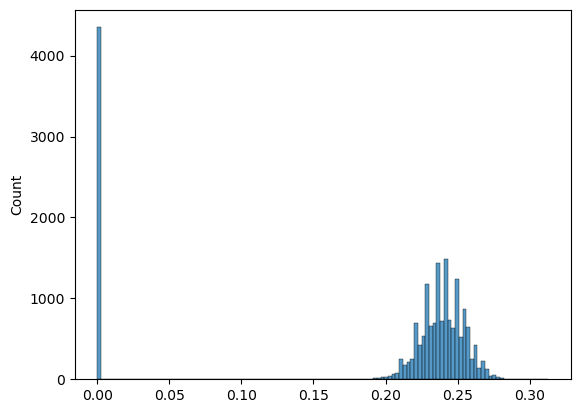

In [42]:
sns.histplot(tr_stan.posterior.z.std("draw").values.ravel())

<AxesSubplot: ylabel='Count'>

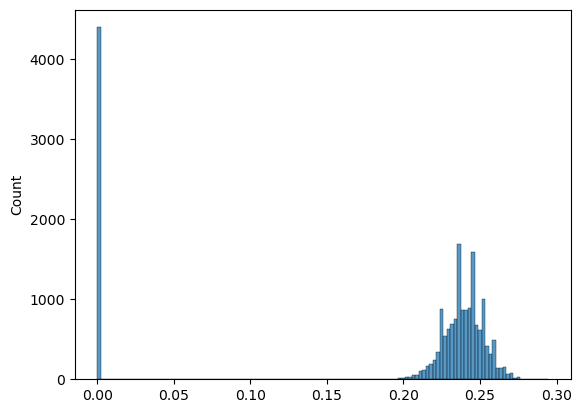

In [43]:
sns.histplot(tr.posterior.z.std("draw").values.ravel())

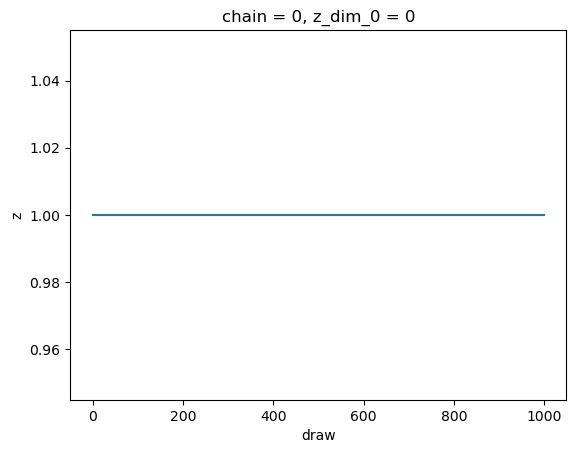

In [38]:
tr_stan.posterior.z.isel(chain=0, z_dim_0=0).plot()

In [21]:
tr.sample_stats.diverging.sum()

<xarray.DataArray 'diverging' ()>
array(0)

In [22]:
tr_stan.sample_stats.diverging.sum()

<xarray.DataArray 'diverging' ()>
array(0)

In [84]:
p = list(db.posteriors())[0]

In [104]:
p.model.code("stan")

'data {\n  int<lower=0> n;       // Number of years\n  int<lower=0> C[n];    // Counts\n  vector[n] year;       // Year\n}\n\ntransformed data {\n  vector[n] year_squared;\n  vector[n] year_cubed;\n\n  year_squared = year .* year;\n  year_cubed = year .* year .* year;\n}\n\nparameters {\n  real<lower=-20,upper=20> alpha;\n  real<lower=-10,upper=10> beta1;\n  real<lower=-10,upper=20> beta2;\n  real<lower=-10,upper=10> beta3;\n  vector[n] eps;        // Year effects\n  real<lower=0,upper=5> sigma;\n}\n\ntransformed parameters {\n  vector[n] log_lambda;\n\n  // Linear predictor incl. random year effect\n log_lambda = alpha\n            + beta1 * year\n            + beta2 * year_squared\n            + beta3 * year_cubed\n            + eps;\n}\n\nmodel {\n  // Priors\n  alpha ~ uniform(-20, 20);\n  beta1 ~ uniform(-10, 10);\n  beta2 ~ uniform(-10, 10);\n  beta3 ~ uniform(-10, 10);\n  sigma ~ uniform(0, 5);\n\n  // Likelihood\n  C ~ poisson_log(log_lambda);\n  eps ~ normal(0, sigma);\n}\n\ng

In [63]:
name = names[0]

In [66]:
ok = 0
for name in names:
    try:
        db.data(name)
        ok += 1
    except FileNotFoundError:
        pass

In [67]:
ok

0

In [34]:
db = pathlib.Path("../../posteriordb/posterior_database/")

In [37]:
data = db / "data/data"

In [39]:
#list(data.iterdir())

In [40]:
models_path = db / "models/stan"

In [41]:
stan = list(models_path.iterdir())[0]

In [43]:
name = stan.stem

In [49]:
name

'2pl_latent_reg_irt'

In [48]:
(data / name).with_suffix(".json.zip")

FileNotFoundError: [Errno 2] No such file or directory: '../../posteriordb/posterior_database/data/data/2pl_latent_reg_irt.json.zip'